# Tutorial 2 Run HRCHY-CytoCommunity on 18 Mouse hypothalamic preoptic region MERFISH dataset
Creator: Runzhi xie (rzxie@stu.xidian.edu.cn).

Affiliation: xidian University, Gao Lab

Date of Creation: 10.10.2025

Date of Last Modification: 10.10.2025

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
from sklearn.neighbors import kneighbors_graph
import datetime
from typing import Optional
from hrchy_cytocommunity.models.dataset import SpatialOmicsImageDataset
from hrchy_cytocommunity.models import HRCHYCytoCommunity, HRCHYCytoCommunityGrand
from hrchy_cytocommunity.visualization.visualization import load_base_data, vis_heatmap
from hrchy_cytocommunity.models.auto_k import HRCHYClusterAutoK, _dd_list,_dd_float

## prepare input data
### construct k-nn graph

In [ ]:
def compute_knn(coords, K, sample_id, save_folder: Optional[str] = None):
    """
    construct KNN graph and save it into file
    
    参数:
    coords: (n, 2) ndarray, the coordinates of cells
    K: the number of nearest neighbors
    sample_id: sample id
    
    save_folder: the path of HRCHY-CytoCommunity input data
    """
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print(f'Constructing KNN graph for {len(coords)} points...')
    A = kneighbors_graph(coords, K, mode='connectivity', include_self=False, n_jobs=-1)  # CSR

    A = A.maximum(A.T).tocsr()
    A.eliminate_zeros()
    A.sort_indices()

    src, dst = A.nonzero()
    edge_index = np.vstack((src, dst)).astype(np.int64) 
    edge_index = edge_index.T # or int32
    if save_folder is not None:
        filename = os.path.join(save_folder, f"{sample_id}_EdgeIndex.txt")
        np.savetxt(filename, edge_index, delimiter='\t', fmt='%d')
        print(f"Saved {len(edge_index)} edges to {filename}")
        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    return edge_index

In [4]:
K = 100 # number of nearest neighbors
input_dir0 = './example_data/MERFISH/raw'
sample_list = ['bregma-0.14']
setting = f'KNN_{K}'
for i,sample_id in enumerate(sample_list):
    coords = np.loadtxt(f"{input_dir0}/{sample_id}_Coordinates.txt")
    print(f"{sample_id} is processing!")
    compute_knn(coords,K=K,sample_id=sample_id,save_folder=input_dir0)
    #print(len(set(adata.obs['region'])))

bregma-0.14 is processing!
2025-10-10 22:28:22
Constructing KNN graph for 5926 points...
Saved 639294 edges to ./example_data/MERFISH/raw/bregma-0.14_EdgeIndex.txt
2025-10-10 22:28:23


## run HRCHY-CytoCommunity pipeline
finish training within 2mins (RTX4090)

In [ ]:
data_input_dir = './example_data/MERFISH'
save_dir = './results/MERFISH/'
dataset = SpatialOmicsImageDataset(data_input_dir)
graph_dict = {
    'bregma-0.14':0,    # the index of graph in dataset
}
model_params = {
        'mode' : 'full',       # full HRCHYCytoCommunity model
        's' : 5,                # number of perturbations
        'num_tcn1' : 12,        # number of fine-grained TC
        'num_tcn2' : 2,        # number of coarse-grained TC
        'num_epoch' : 1500,
        'lambda1':1,           # Coefficient of consistency regularization
        'lambda_balance':1,     # Coefficient of cluster balance regularization
        'num_hidden' : 128,     # the dimension of hidden layer
        'lr' : 1e-4,            # learning rate
        'drop_rate' : 0.5,      # rate of drop node
        'gt_fine':True,        # whether input data contain fine-grained CN ground truth
        'gt_coarse':False,       # whether input data contain coarse-grained TC ground truth
        'device':'cuda:0'       # training device, if no gpu, set 'cpu'
        }

In [ ]:
HyperPara_df = pd.DataFrame(model_params.items(), columns=['Parameter', 'Value'])
if not os.path.exists(os.path.join(save_dir)):
    os.makedirs(os.path.join(save_dir))
HyperPara_df.to_csv(os.path.join(save_dir,'HyperPara.csv'))
for slice_name,graph_idx in graph_dict.items():
    print(f"{slice_name} is processing")
    train_dataset = dataset[graph_idx]
    cell_meta = load_base_data(os.path.join(data_input_dir,'raw'),
                            graph_idx,fine_GT=model_params['gt_fine'],
                            coarse_GT=model_params['gt_coarse'])
    cell_meta = cell_meta
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    if model_params['mode'] == 'base':
        hrchycytocommunity = HRCHYCytoCommunity(
            dataset = train_dataset,
            num_tcn1 = model_params['num_tcn1'],
            num_tcn2 = model_params['num_tcn2'],
            cell_meta = cell_meta,
            lr = model_params['lr'],
            num_epoch = model_params['num_epoch'],
            lambda1 = model_params['lambda1'],
            lambda_balance = model_params['lambda_balance'],
            device = model_params['device'],
            gt_coarse=model_params['gt_coarse'],
            gt_fine=model_params['gt_fine'],
        )
    elif  model_params['mode'] == 'full':
        hrchycytocommunity = HRCHYCytoCommunityGrand(
            dataset = train_dataset,
            num_tcn1 = model_params['num_tcn1'],
            num_tcn2 = model_params['num_tcn2'],
            cell_meta = cell_meta,
            lr = model_params['lr'],
            num_epoch = model_params['num_epoch'],
            lambda1 = model_params['lambda1'],
            lambda_balance = model_params['lambda_balance'],
            s = model_params['s'],
            drop_rate = model_params['drop_rate'],
            device = model_params['device'],
            gt_coarse=model_params['gt_coarse'],
            gt_fine=model_params['gt_fine'],
        )
    ret_output_dir = os.path.join(save_dir,slice_name)
    hrchycytocommunity.train(save_dir=ret_output_dir, # path to save output results
                             output=False,    # whether print out training information during training
                             vis_while_training=True    # whether visualize clustering results during training
                             )
    hrchycytocommunity.predict(save = True,save_dir=ret_output_dir)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

bregma-0.14 is processing
2025-10-10 22:46:35
edge_pruning_cutoff = 0.09090909090909091


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:59<00:00, 25.24it/s]

2025-10-10 22:47:35


## visualize result

### define mapping function to map identified CN to ground truth cn

In [65]:
from scipy.optimize import linear_sum_assignment
import numpy as np
def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    # y = np.array(y, dtype=np.int64)
    val_set = sorted(list(set(y)))
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y

def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    
    d = {ind[0][i]:ind[1][i] for i in range(len(ind[0]))}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred,d


In [71]:
x_label = 'x_coordinate'
y_label = 'y_coordinate'
dict_color_TC = {0: "#e41a1c", 1: "#377eb8"}
dict_color = {"BNST": "#54a9dd", 
                   "ACA": "#231f1f", 
                   "LPO": "#939396",
                   "MPA": "#d63189",
                    "VMPO": "#d8de52",
                    "Pe": "#2c663b", 
                    "PaAP": "#FFA500", 
                    "MnPO": "#ff0000", 
                    "VLPO": "#a17f56", 
                    "AVPe": "#5d3288", 
                    'MPA': "#d63189", 
                    "PS": "#7FBA77", 
                    "3V": "#f5deb3", 
                    "PVA": "#813188", 
                    "StHy": "#5a3b1c",
                    "MPN": "#912b61",
                    "BAC":"#C29CC2",
                    "Fx":"#231f1f",
                    "SHy":"#E58361"}

#### load hierarchical tissue structure assignment

In [ ]:
cell_meta = load_base_data(os.path.join(data_input_dir,'raw'),
                        graph_idx,fine_GT=model_params['gt_fine'],
                        coarse_GT=model_params['gt_coarse'])
fine_cluster_id = pd.read_csv(f"{save_dir}/{slice_name}/fine_ClusterAssignMatrix_hard.csv",header=None)[0].tolist()
coarse_cluster_id = pd.read_csv(f"{save_dir}/{slice_name}/coarse_ClusterAssignMatrix_hard.csv",header=None)[0]
coarse_cluster_id = coarse_cluster_id[fine_cluster_id].tolist()
cell_meta['coarse_cluster'] = coarse_cluster_id
cell_meta['fine_cluster'] = fine_cluster_id

In [77]:
cell_meta_no_na = cell_meta[~cell_meta['fine_GT'].isna()]
y_true,y_pred,d = hungarian_match(cell_meta_no_na['fine_GT'].tolist(),cell_meta_no_na['fine_cluster'].tolist())
gt_labels = sorted(list(set(cell_meta_no_na['fine_GT'])))
gt_mapping = {val:i for  i,val in enumerate(gt_labels)}
cell_meta['fine_cluster'] = [d[v] for v in cell_meta['fine_cluster'].astype(int).tolist()]
# cell_meta['fine_cluster'] = [d[v] for v in cell_meta['fine_cluster'].astype(int).tolist()]
dict_color_TCN1 = {gt_mapping[gt]:dict_color[gt] for gt in gt_labels}
dict_color_TCN1[9] = '#DEBD76'
dict_color_TCN1[10] = '#B6D7B8'
dict_color_TCN1[11] = "#CEBACB"

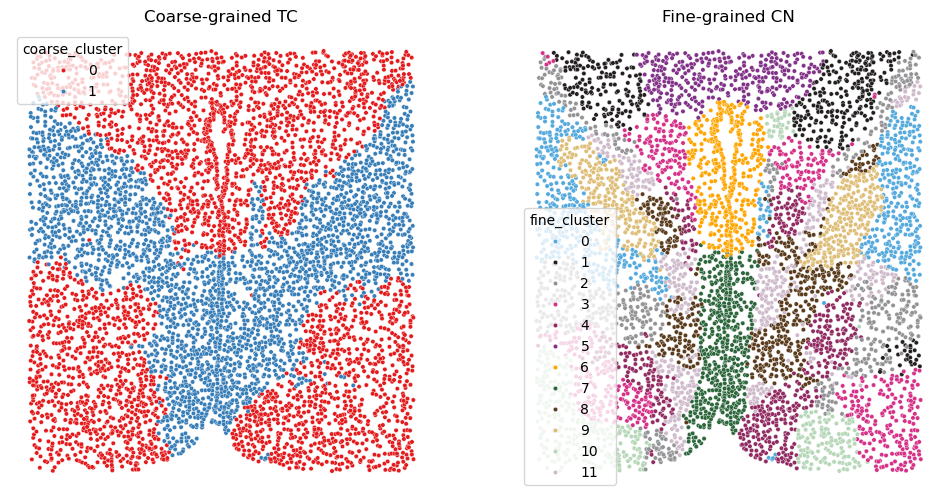

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = cell_meta[[x_label,y_label]].copy()
df['coarse_cluster'] = cell_meta['coarse_cluster'].to_list()
df['fine_cluster'] = cell_meta['fine_cluster'].to_list()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# left：coarse cluster
sns.scatterplot(
    x=x_label, y=y_label,
    data=df,
    hue='coarse_cluster',
    legend=True,
    s=10,
    palette=dict_color_TC,
    alpha=1.0,
    ax=axes[0]
)
axes[0].set_title("Coarse-grained TC")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
# axes[0].invert_yaxis()
sns.despine(ax=axes[0], left=True, bottom=True)

# right：fine cluster
sns.scatterplot(
    x=x_label, y=y_label,
    data=df,
    hue='fine_cluster',
    legend=True,
    s=10,
    palette=dict_color_TCN1,
    alpha=1.0,
    ax=axes[1]
)
axes[1].set_title("Fine-grained CN")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
# axes[1].invert_yaxis()  # Invert y-axis to match image coordinate system
sns.despine(ax=axes[1], left=True, bottom=True)
plt.show()
